In [2]:
import pandas as pd
import re
from datetime import datetime

# --- CONFIGURATION ---
FILE_PATH = r'C:\Users\Neeraja\Downloads\BOX-SCORE-13-03-2025-TO-13-04-2025.xlsx'  # <-- update if necessary
SHEET_NAME = 'BOX SCORE'
OUTPUT_FILENAME = "box_score_analysis_FINAL11.xlsx"
# ---------------------

def parse_date(value):
    """Parses dates from string (various formats)."""
    if not isinstance(value, str): return None
    value = str(value).split(' ')[0]
    for fmt in ('%Y-%m-%d', '%d-%m-%Y', '%d.%m.%y', '%d/%m/%Y', '%d/%m/%y'):
        try:
            return pd.to_datetime(value, format=fmt).strftime('%Y-%m-%d')
        except (ValueError, TypeError): continue
    return None

def clean_numeric(value):
    """Cleans and converts to number (float/int), if possible."""
    if pd.isna(value) or str(value).strip() in ['', '-']: return None
    cleaned_str = re.sub(r'[^\d.-]', '', str(value))
    return pd.to_numeric(cleaned_str, errors='coerce') if cleaned_str else None

def process_box_score(file_path, sheet_name='BOX SCORE'):
    # Read the sheet, all cells as string
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, dtype=str).fillna('')
    
    # Find all positions of 'CATEGORY' in column 1
    block_start_markers = df[df[1].str.strip().str.upper() == 'CATEGORY'].index
    if block_start_markers.empty:
        print("Cannot find any 'CATEGORY' header rows.")
        return None, None, None

    all_metrics_data, all_performance_data, all_salary_data = [], [], []

    for i, start_row in enumerate(block_start_markers):
        block_start = max(0, start_row - 17)  # adjust if metrics table starts differently
        block_end = block_start_markers[i+1] if i+1 < len(block_start_markers) else len(df)
        block_df = df.iloc[block_start:block_end].reset_index(drop=True)
        if block_df.empty:
            continue
        # Date is one row after 'CATEGORY' header, first column
        date_row_in_block = (start_row - block_start) + 1
        if date_row_in_block >= len(block_df):
            continue
        date_str = parse_date(block_df.iloc[date_row_in_block][0])
        if not date_str:
            continue

        # Extract Metrics
        try:
            products_row_idx = block_df[block_df[2].str.strip().str.upper() == 'FEED PUMP'].index[0]
            products = block_df.iloc[products_row_idx].tolist()
            metric_rows = block_df[block_df[1].str.contains('Unit per|Shipment|Days|Cost|REVENUE|Capacity|Profit', na=False, case=False)]
            metric_categories = {
                'Operational': ['Unit per', 'Shipment', 'Days', 'Cost'],
                'Capacity': ['Productive', 'Available'],
                'Financial': ['REVENUE', 'Material', 'Conversion', 'Profit']
            }
            for _, row in metric_rows.iterrows():
                metric_name = row[1].strip()
                metric_cat = next(
                    (cat for cat, keys in metric_categories.items()
                     if any(key.lower() in metric_name.lower() for key in keys)), 'Unknown')
                for col_idx, product_name in enumerate(products):
                    if col_idx < 2 or not isinstance(product_name, str) or product_name.strip() == '': continue
                    if col_idx < len(row) and pd.notna(row[col_idx]) and str(row[col_idx]).strip() not in ['-', '']:
                        all_metrics_data.append({
                            'Date': date_str,
                            'Product Category': product_name.strip(),
                            'Metric Category': metric_cat,
                            'Metric Name': metric_name,
                            'Value': clean_numeric(row[col_idx])
                        })
        except Exception: pass

        # Extract Performance and Failure
        for r in range(date_row_in_block, len(block_df)):
            perf_row = block_df.iloc[r]
            category = perf_row[1].strip()
            if category == '' or 'SALARY' in category.upper(): continue
            # date in first column should be either blank or match
            if perf_row[0] not in ['', date_str]: continue
            plan = clean_numeric(perf_row[2])
            actual = clean_numeric(perf_row[3])
            failure = clean_numeric(perf_row[4])
            warehouse_value = clean_numeric(perf_row[5])
            reason_text = perf_row[10].strip() if 10 < len(perf_row) and pd.notna(perf_row[10]) else ''
            all_performance_data.append({
                'Date': date_str,
                'Category': category.replace('\n', ' ').strip(),
                'Plan': plan,
                'Actual': actual,
                'Failure': failure,
                'Warehouse Value': warehouse_value,
                'Failure Reason': reason_text
            })

        # Extract Salary
        try:
            salary_rows = block_df[block_df.apply(lambda r: r.astype(str).str.contains('SALARY', case=False).any(), axis=1)]
            for _, salary_row in salary_rows.iterrows():
                for col_idx, cell_value in enumerate(salary_row):
                    if 'SALARY' in str(cell_value).upper():
                        label = str(cell_value).strip()
                        value_col_idx = col_idx + 1
                        if value_col_idx < len(salary_row):
                            value = clean_numeric(salary_row[value_col_idx])
                            if label and value is not None:
                                all_salary_data.append({
                                    'Date': date_str,
                                    'Salary Item': label,
                                    'Value': value
                                })
                                break
        except Exception: pass

    # DataFrames
    metrics = pd.DataFrame(all_metrics_data)
    performance = pd.DataFrame(all_performance_data)
    salary = pd.DataFrame(all_salary_data)

    return metrics, performance, salary

# --- Save extracted data ---
if __name__ == "__main__":
    metrics, performance, salary = process_box_score(FILE_PATH, SHEET_NAME)
    if metrics is not None and not metrics.empty:
        with pd.ExcelWriter(OUTPUT_FILENAME, engine='openpyxl') as writer:
            metrics.to_excel(writer, sheet_name='Product Metrics Summary', index=False)
            performance.to_excel(writer, sheet_name='Performance and Failure', index=False)
            salary.to_excel(writer, sheet_name='Daily Salary Details', index=False)
        print(f"✅ File saved as '{OUTPUT_FILENAME}' with all detected reports.")
    else:
        print("❌ No data extracted. Check raw file format or logic.")


✅ File saved as 'box_score_analysis_FINAL11.xlsx' with all detected reports.


In [5]:
import pandas as pd
import numpy as np

# Load processed data
file_path = 'box_score_analysis_FINAL11.xlsx'
metrics_df = pd.read_excel(file_path, sheet_name='Product Metrics Summary')
performance_df = pd.read_excel(file_path, sheet_name='Performance and Failure')
salary_df = pd.read_excel(file_path, sheet_name='Daily Salary Details')

# -------- FEATURE ENGINEERING --------

# 1. FAILURE RATE for each Category (Failure / Actual)
failure_rate_df = (
    performance_df.groupby('Category')[['Failure', 'Actual']]
    .sum()
    .assign(Failure_Rate=lambda x: x['Failure'] / x['Actual'].replace({0: np.nan}))
    .reset_index()
)

# Merge Failure_Rate into performance_df
performance_df = performance_df.merge(
    failure_rate_df[['Category', 'Failure_Rate']],
    on='Category',
    how='left'
)

# 2. UTILIZATION RATE (Actual / Plan) for each row, handling zero or null Plan
performance_df['Utilization_Rate'] = performance_df.apply(
    lambda row: row['Actual'] / row['Plan']
    if pd.notnull(row['Plan']) and row['Plan'] not in [0, '', '-', None]
    and pd.notnull(row['Actual']) else np.nan,
    axis=1
)

# 3. PROFIT MARGIN (if metrics_df contains 'Profit' & 'Revenue' columns)
if 'Profit' in metrics_df.columns and 'Revenue' in metrics_df.columns:
    metrics_df['Profit_Margin'] = metrics_df.apply(
        lambda row: row['Profit'] / row['Revenue']
        if pd.notnull(row['Revenue']) and row['Revenue'] not in [0, '', '-', None]
        and pd.notnull(row['Profit']) else np.nan,
        axis=1
    )

# 4. Any additional features (e.g., categorize by Dock-to-Dock Days, high/low shipment, cost buckets)
# Example: metrics_df['High_Shipment'] = metrics_df['Metric Name'].apply(lambda v: v == 'On-Time Shipment' and metrics_df['Value'] > 80)

# 5. Save engineered features for use in modeling
performance_df.to_excel('engineered_performance_features.xlsx', index=False)
metrics_df.to_excel('engineered_metrics_features.xlsx', index=False)

print('Feature engineering complete. Engineered datasets are saved.')


Feature engineering complete. Engineered datasets are saved.


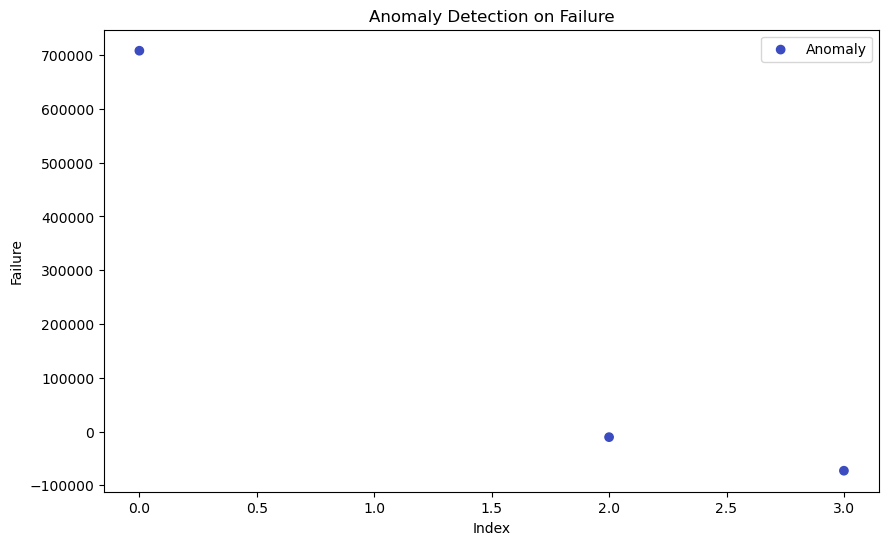

Anomalies detected and results saved.


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Load engineered features
df = pd.read_excel('engineered_performance_features.xlsx')

# Select features for anomaly detection (customize with your engineered columns)
features = ['Failure', 'Actual', 'Failure_Rate', 'Utilization_Rate']
X = df[features].replace([np.inf, -np.inf], np.nan).fillna(0)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X)

# Label anomalies (-1 means anomaly, 1 means normal)
df['is_anomaly'] = df['anomaly_score'].map({-1: 'Anomaly', 1: 'Normal'})

# Simple visualization
plt.figure(figsize=(10,6))
plt.scatter(df.index, df['Failure'], c=(df['is_anomaly'] == 'Anomaly'), cmap='coolwarm', label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Failure')
plt.title('Anomaly Detection on Failure')
plt.legend()
plt.show()

# Export anomalies for inspection
df[df['is_anomaly'] == 'Anomaly'].to_excel('anomalies_detected.xlsx', index=False)
print("Anomalies detected and results saved.")


In [7]:
# 1. Prepare Data for Modeling


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load engineered features
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Create engineered features if missing
grouped = df.groupby('Category')[['Failure', 'Actual']].sum()
rate_map = (grouped['Failure'] / grouped['Actual'].replace({0: np.nan})).to_dict()
df['Failure_Rate'] = df['Category'].map(rate_map)
df['Utilization_Rate'] = df.apply(
    lambda row: row['Actual']/row['Plan']
    if pd.notnull(row['Plan']) and row['Plan'] not in [0, '', '-', None] and pd.notnull(row['Actual']) else np.nan,
    axis=1
)

# Encode Category if necessary
from sklearn.preprocessing import LabelEncoder
if 'Category_enc' not in df.columns:
    df['Category_enc'] = LabelEncoder().fit_transform(df['Category'].astype(str))

# Features and target
features = ['Actual', 'Plan', 'Failure_Rate', 'Utilization_Rate', 'Category_enc']
X = df[features].fillna(0)
y = df['Failure'].fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R^2:", r2_score(y_test, preds))


MAE: 0.0
RMSE: 0.0
R^2: 1.0


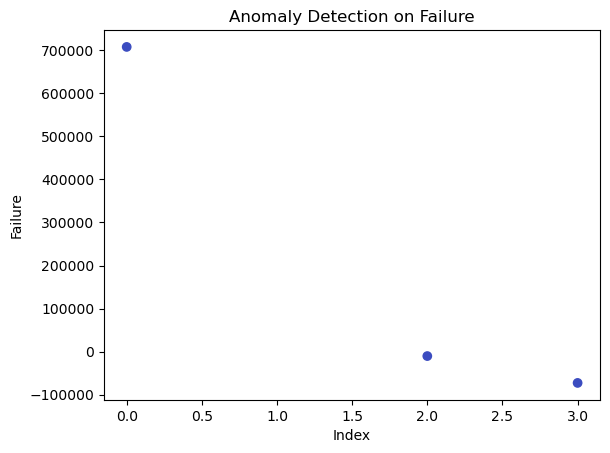

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

Confusion Matrix:
[[59]]


C:\Users\Neeraja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Regression MAE: 0.0
Regression RMSE: 0.0
Regression R^2: 1.0


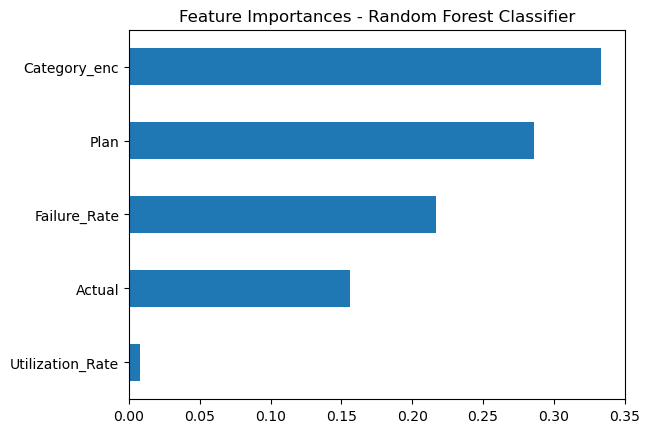

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Load your data
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Feature engineering
grouped = df.groupby('Category')[['Failure', 'Actual']].sum()
rate_map = (grouped['Failure'] / grouped['Actual'].replace({0: np.nan})).to_dict()
df['Failure_Rate'] = df['Category'].map(rate_map)
df['Utilization_Rate'] = df.apply(
    lambda row: row['Actual'] / row['Plan']
    if pd.notnull(row['Plan']) and row['Plan'] not in [0, '', '-', None] and pd.notnull(row['Actual']) else np.nan,
    axis=1
)
df['Category_enc'] = LabelEncoder().fit_transform(df['Category'].astype(str))

# ------------------
# Anomaly Detection (Isolation Forest)
features_anomaly = ['Failure', 'Actual', 'Failure_Rate', 'Utilization_Rate']
X_anomaly = df[features_anomaly].fillna(0)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_flag'] = iso_forest.fit_predict(X_anomaly)
df['is_anomaly'] = df['anomaly_flag'].map({-1: 'Anomaly', 1: 'Normal'})

plt.scatter(df.index, df['Failure'], c=(df['is_anomaly'] == 'Anomaly'), cmap='coolwarm')
plt.xlabel('Index')
plt.ylabel('Failure')
plt.title('Anomaly Detection on Failure')
plt.show()

# ------------------
# Classification Target
df['Fail_Label'] = (df['Failure'] > 0).astype(int)

# Features for classification
features = ['Actual', 'Plan', 'Failure_Rate', 'Utilization_Rate', 'Category_enc']
X_class = df[features].fillna(0)
y_class = df['Fail_Label']

# Train-test split WITHOUT stratify due to class imbalance
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Random Forest Classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_c, y_train_c)
y_pred_c = rf_classifier.predict(X_test_c)

print("Classification Report:")
print(classification_report(y_test_c, y_pred_c))
print("Confusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_c))

# ------------------
# Regression Target
y_reg = df['Failure'].fillna(0)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_class, y_reg, test_size=0.2, random_state=42
)

# Random Forest Regression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_r, y_train_r)
y_pred_r = rf_regressor.predict(X_test_r)

print("Regression MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("Regression RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_r)))
print("Regression R^2:", r2_score(y_test_r, y_pred_r))

# Feature importance visualization for classification
importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values()
importances.plot(kind='barh', title='Feature Importances - Random Forest Classifier')
plt.show()


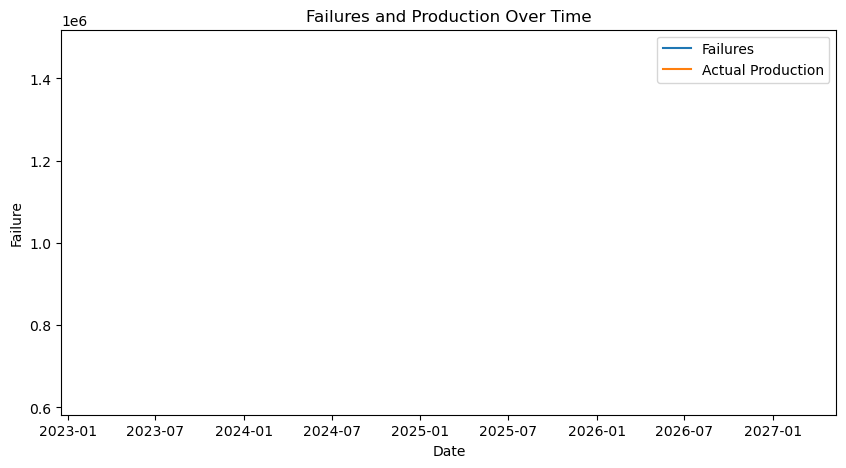

Correlation matrix:
                   Failure_Rate  Utilization_Rate   Failure
Failure_Rate          1.000000         -0.987101  0.999727
Utilization_Rate     -0.987101          1.000000 -0.990573
Failure               0.999727         -0.990573  1.000000
Category benchmark summary:
                             Failure    Actual  Failure_Rate Utilization_Rate
Category                                                                    
WATER PUMP                 708002.0  259978.0      2.723315         0.268578
Account Receivable Days         0.0       0.0           NaN              NaN
Available Capacity              0.0   29000.0      0.000000              2.0
Average Product Cost            0.0       0.0           NaN              NaN
Conversion Cost                 0.0   25984.0      0.000000         0.048242
Dock-to-Dock Days               0.0   11078.0      0.000000              NaN
First Time Through              0.0       0.0           NaN              NaN
Material Cost        

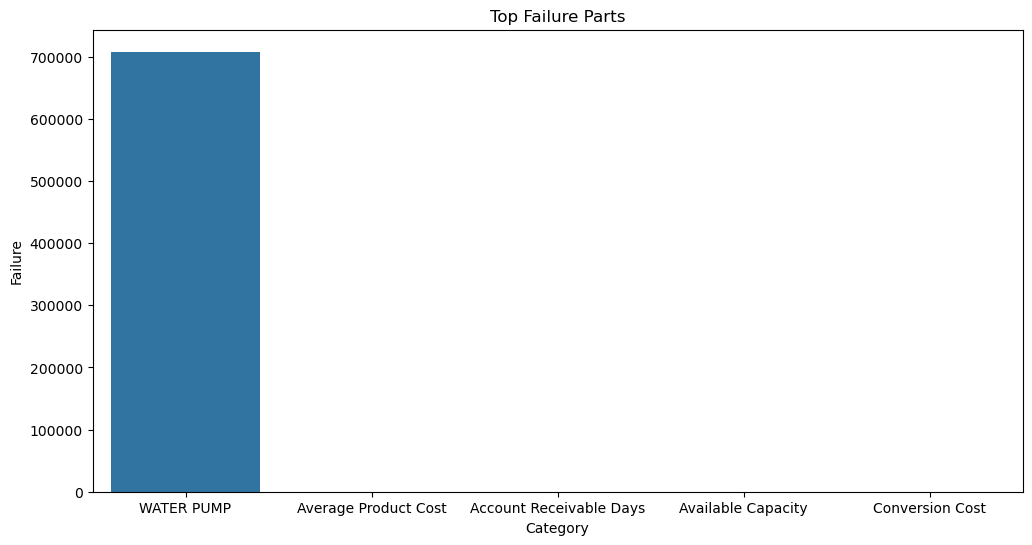

Cost impact summary by Category:
                             Failure  Warehouse Value
Category                                            
Value Stream Gross Profit       0.0        1184366.0
Material Cost                   0.0         725136.0
WATER PUMP                 708002.0         614498.0
PCN                             0.0         357264.0
PULLEY                     -72786.0         156665.0
COOLANT ELBOW & COVERS     -10353.0          45206.0
Conversion Cost                 0.0          25984.0
Available Capacity              0.0          14500.0
Non Productive                  0.0          14500.0
Account Receivable Days         0.0              0.0
Average Product Cost            0.0              0.0
Dock-to-Dock Days               0.0              0.0
First Time Through              0.0              0.0
On-Time Shipment                0.0              0.0
Estimated reductions with improved utilization:
                  Category   Failure Estimated_Failure_Reduced
0      

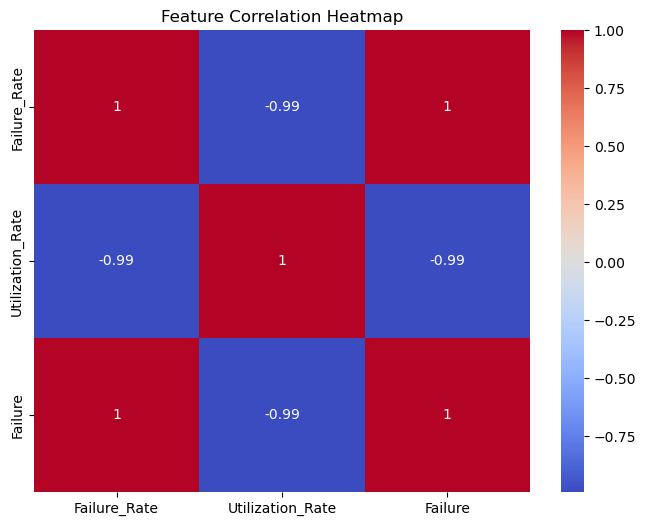

Completed all analyses successfully.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Ensure engineered features exist or recalculate
if 'Failure_Rate' not in df.columns or df['Failure_Rate'].isna().all():
    grouped = df.groupby('Category')[['Failure', 'Actual']].sum()
    rate_map = (grouped['Failure'] / grouped['Actual'].replace({0: pd.NA})).to_dict()
    df['Failure_Rate'] = df['Category'].map(rate_map)

if 'Utilization_Rate' not in df.columns or df['Utilization_Rate'].isna().all():
    df['Utilization_Rate'] = df.apply(
        lambda row: row['Actual'] / row['Plan']
        if pd.notnull(row['Plan']) and row['Plan'] not in [0, '', '-', None] and pd.notnull(row['Actual']) else pd.NA,
        axis=1
    )

# Convert Date column to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])

# 1. Time Series and Trend Analysis
if 'Date' in df.columns:
    time_series = df.groupby('Date').agg({
        'Failure': 'sum',
        'Actual': 'sum',
        'Failure_Rate': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=time_series, x='Date', y='Failure', label='Failures')
    sns.lineplot(data=time_series, x='Date', y='Actual', label='Actual Production')
    plt.title('Failures and Production Over Time')
    plt.legend()
    plt.show()

# 2. Failure and Maintenance Correlation
corr_features = ['Failure_Rate', 'Utilization_Rate', 'Failure']
df_corr = df[corr_features].dropna()
corr_matrix = df_corr.corr()

print("Correlation matrix:\n", corr_matrix)

# 3. Part and Category Performance Benchmarks
category_summary = df.groupby('Category').agg({
    'Failure': 'sum',
    'Actual': 'sum',
    'Failure_Rate': 'mean',
    'Utilization_Rate': 'mean'
}).sort_values('Failure', ascending=False)
print("Category benchmark summary:\n", category_summary)

# 4. Failure Rate Hotspots
top_failure_parts = category_summary.head(5).index.tolist()
df_top_parts = df[df['Category'].isin(top_failure_parts)]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_parts, x='Category', y='Failure')
plt.title('Top Failure Parts')
plt.show()

# 5. Cost and Revenue Impact Analysis
if 'Warehouse Value' in df.columns:
    cost_summary = df.groupby('Category').agg({
        'Failure': 'sum',
        'Warehouse Value': 'sum'
    }).sort_values('Warehouse Value', ascending=False)
    print("Cost impact summary by Category:\n", cost_summary)

# 6. Simulation-Based What-if Analyses
df['Utilization_Improved'] = df['Utilization_Rate'] * 1.05
df['Estimated_Failure_Reduced'] = df['Failure'] * (df['Utilization_Rate'] / df['Utilization_Improved'])
print("Estimated reductions with improved utilization:\n", df[['Category', 'Failure', 'Estimated_Failure_Reduced']].head())

# 7. Visualization and Dashboards
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

print("Completed all analyses successfully.")


In [18]:
# 1. Root Cause Analysis (Common Failure Reasons)


Top Failure Reasons:
 Failure Reason
-                                                                                                           35
3000                                                                                                         3
61                                                                                                           2
9616                                                                                                         2
32560000- 200 Nos\nIR pending due to 26220005 Seal stock issue\n35060000- 300 Nos IR done in todays date     1
No plan since people involved in cleaning process                                                            1
35628                                                                                                        1
14300                                                                                                        1
615                                                                        

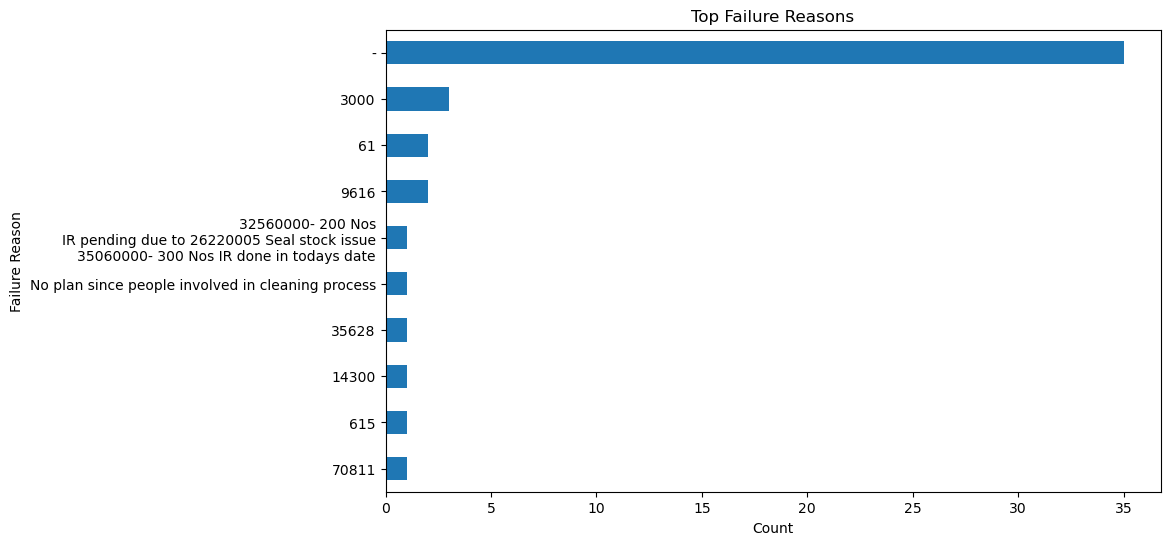

In [19]:
# Count top unique failure reasons
failure_reasons = df['Failure Reason'].dropna()
top_failure_reasons = failure_reasons.value_counts().head(10)
print("Top Failure Reasons:\n", top_failure_reasons)

# Plot
top_failure_reasons.plot(kind='barh', figsize=(10,6), title="Top Failure Reasons")
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.show()


In [20]:
# 2. Process Efficiency Analysis (KPI Overview)


In [24]:
kpi_cols = ['Dock-to-Dock Days', 'On-Time Shipment', 'First Time Through']
existing_kpis = [col for col in kpi_cols if col in df.columns]
print("Available KPIs:", existing_kpis)

for kpi in existing_kpis:
    df[kpi].hist(bins=30)
    plt.title(f'Distribution of {kpi}')
    plt.xlabel(kpi)
    plt.ylabel('Frequency')
    plt.show()
print("All available columns in dataset:")
print(df.columns.tolist())



Available KPIs: []
All available columns in dataset:
['Date', 'Category', 'Plan', 'Actual', 'Failure', 'Warehouse Value', 'Failure Reason', 'Failure_Rate', 'Utilization_Rate', 'Utilization_Improved', 'Estimated_Failure_Reduced']


In [22]:
# 3. Cost and Profit Analysis


In [23]:
# Summarize costs and profits by category
if 'Profit Margin' in df.columns:
    cost_profit_summary = df.groupby('Category').agg({
        'Warehouse Value': 'sum',
        'Profit Margin': 'mean'
    }).sort_values('Warehouse Value', ascending=False)
    print(cost_profit_summary)


Creating engineered features:
Failure_Rate and Utilization_Rate created.

Cost Analysis by Category:
                            Failure  Warehouse Value
Category                                            
Value Stream Gross Profit       0.0        1184366.0
Material Cost                   0.0         725136.0
WATER PUMP                 708002.0         614498.0
PCN                             0.0         357264.0
PULLEY                     -72786.0         156665.0
COOLANT ELBOW & COVERS     -10353.0          45206.0
Conversion Cost                 0.0          25984.0
Available Capacity              0.0          14500.0
Non Productive                  0.0          14500.0
Account Receivable Days         0.0              0.0
Average Product Cost            0.0              0.0
Dock-to-Dock Days               0.0              0.0
First Time Through              0.0              0.0
On-Time Shipment                0.0              0.0


Performing Pareto analysis on Failures:


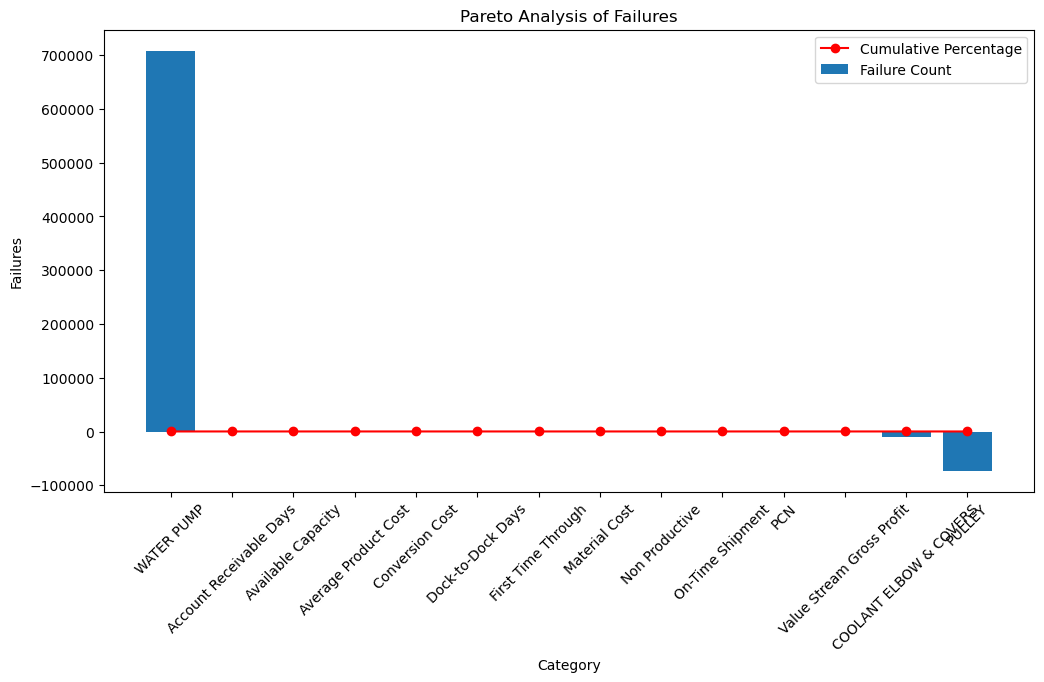



Running clustering and segmentation:


C:\Users\Neeraja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


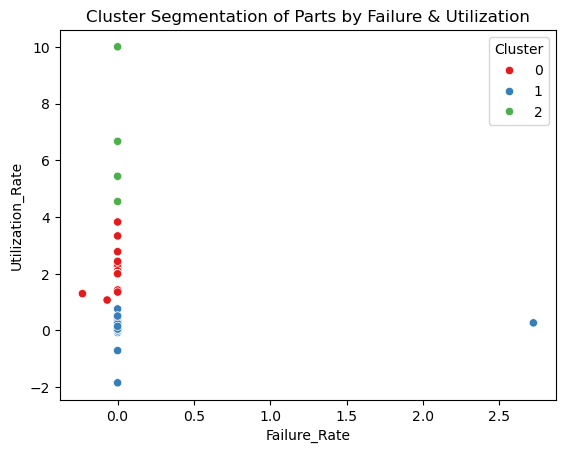

All requested analyses completed successfully.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Create engineered features
print("Creating engineered features:")
grouped = df.groupby('Category')[['Failure', 'Actual']].sum()
rate_map = (grouped['Failure'] / grouped['Actual'].replace({0: np.nan})).to_dict()
df['Failure_Rate'] = df['Category'].map(rate_map)

df['Utilization_Rate'] = df.apply(
    lambda row: row['Actual'] / row['Plan']
    if pd.notnull(row['Plan']) and row['Plan'] != 0 and pd.notnull(row['Actual']) else np.nan,
    axis=1
)
print("Failure_Rate and Utilization_Rate created.\n")

# 3. Cost and Profit Analysis (adapted: no Profit Margin, only Warehouse Value)
print("Cost Analysis by Category:")
if 'Warehouse Value' in df.columns:
    cost_summary = df.groupby('Category').agg({
        'Failure': 'sum',
        'Warehouse Value': 'sum'
    }).sort_values('Warehouse Value', ascending=False)
    print(cost_summary)
else:
    print("Column 'Warehouse Value' not found; skipping cost analysis.")
print("\n")

# 4. Pareto Analysis (Top Contributors)
print("Performing Pareto analysis on Failures:")
failure_by_category = df.groupby('Category')['Failure'].sum()
failure_sorted = failure_by_category.sort_values(ascending=False)
cumulative_percentage = failure_sorted.cumsum() / failure_sorted.sum() * 100
plt.figure(figsize=(12, 6))
plt.bar(failure_sorted.index, failure_sorted.values, label='Failure Count')
plt.plot(failure_sorted.index, cumulative_percentage.values, color='red', marker='o', label='Cumulative Percentage')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Failures')
plt.title('Pareto Analysis of Failures')
plt.legend()
plt.show()
print("\n")

# 5. Clustering & Segmentation (KMeans on failure and utilization)
print("Running clustering and segmentation:")
# Use created engineered feature names
features = ['Failure_Rate', 'Utilization_Rate']
X = df[features].dropna()
df_clusters = df.loc[X.index].copy()

kmeans = KMeans(n_clusters=3, random_state=42)
df_clusters['Cluster'] = kmeans.fit_predict(X)

sns.scatterplot(data=df_clusters, x='Failure_Rate', y='Utilization_Rate', hue='Cluster', palette='Set1')
plt.title('Cluster Segmentation of Parts by Failure & Utilization')
plt.show()

print("All requested analyses completed successfully.")


In [30]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


Creating Failure_Rate and Utilization_Rate...
Features created.

Cost and Failure Summaries by Category:
                            Failure  Warehouse Value
Category                                            
Value Stream Gross Profit       0.0        1184366.0
Material Cost                   0.0         725136.0
WATER PUMP                 708002.0         614498.0
PCN                             0.0         357264.0
PULLEY                     -72786.0         156665.0
COOLANT ELBOW & COVERS     -10353.0          45206.0
Conversion Cost                 0.0          25984.0
Available Capacity              0.0          14500.0
Non Productive                  0.0          14500.0
Account Receivable Days         0.0              0.0
Average Product Cost            0.0              0.0
Dock-to-Dock Days               0.0              0.0
First Time Through              0.0              0.0
On-Time Shipment                0.0              0.0
Pareto Analysis Plot:


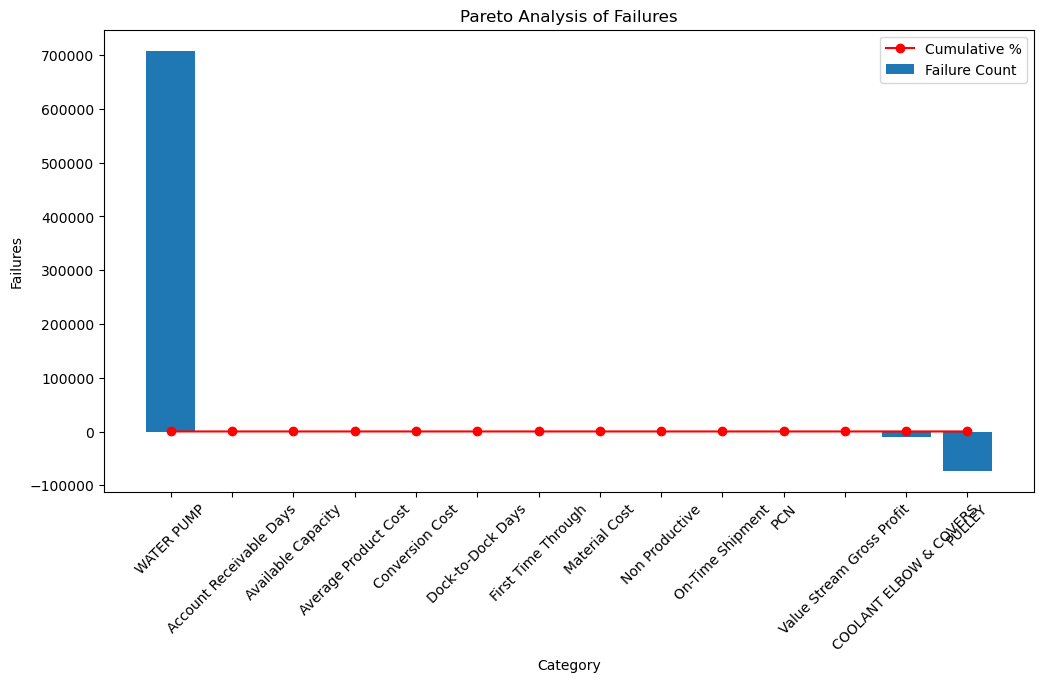

Clustering Analysis:


C:\Users\Neeraja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


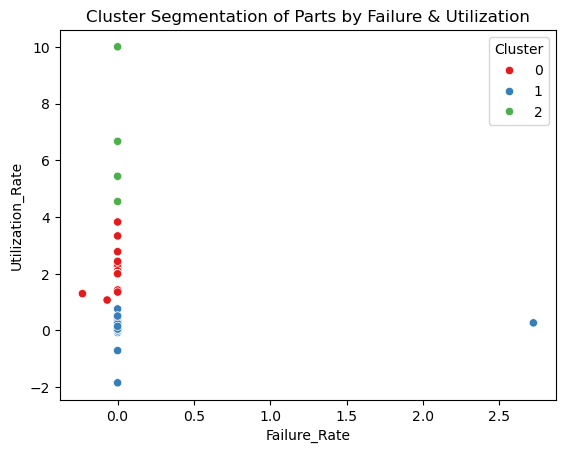

Analysis complete.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import os
os.environ["OMP_NUM_THREADS"] = "1"


# Load dataset
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Engineered Features
print("Creating Failure_Rate and Utilization_Rate...")
grouped = df.groupby('Category')[['Failure', 'Actual']].sum()
rate_map = (grouped['Failure'] / grouped['Actual'].replace({0: np.nan})).to_dict()
df['Failure_Rate'] = df['Category'].map(rate_map)

df['Utilization_Rate'] = df.apply(
    lambda row: row['Actual'] / row['Plan']
    if pd.notnull(row['Plan']) and row['Plan'] != 0 and pd.notnull(row['Actual'])
    else np.nan,
    axis=1
)
print("Features created.\n")

# Cost Analysis
print("Cost and Failure Summaries by Category:")
if 'Warehouse Value' in df.columns:
    cost_summary = df.groupby('Category').agg({
        'Failure': 'sum',
        'Warehouse Value': 'sum'
    }).sort_values('Warehouse Value', ascending=False)
    print(cost_summary)
else:
    print("Column 'Warehouse Value' not found for cost analysis.\n")

# Pareto Analysis
print("Pareto Analysis Plot:")
failure_by_category = df.groupby('Category')['Failure'].sum()
failure_sorted = failure_by_category.sort_values(ascending=False)
cumulative_percentage = failure_sorted.cumsum() / failure_sorted.sum() * 100

plt.figure(figsize=(12,6))
plt.bar(failure_sorted.index, failure_sorted.values, label='Failure Count')
plt.plot(failure_sorted.index, cumulative_percentage.values, color='red', marker='o', label='Cumulative %')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Failures')
plt.title('Pareto Analysis of Failures')
plt.legend()
plt.show()

# Clustering & Segmentation
print("Clustering Analysis:")
features = ['Failure_Rate', 'Utilization_Rate']
X = df[features].dropna()
df_clusters = df.loc[X.index].copy()

kmeans = KMeans(n_clusters=3, random_state=42)
df_clusters['Cluster'] = kmeans.fit_predict(X)

sns.scatterplot(data=df_clusters, x='Failure_Rate', y='Utilization_Rate', hue='Cluster', palette='Set1')
plt.title('Cluster Segmentation of Parts by Failure & Utilization')
plt.show()

print("Analysis complete.")


In [33]:
# 1. Failure Reason Text Analysis (Keyword Frequency)


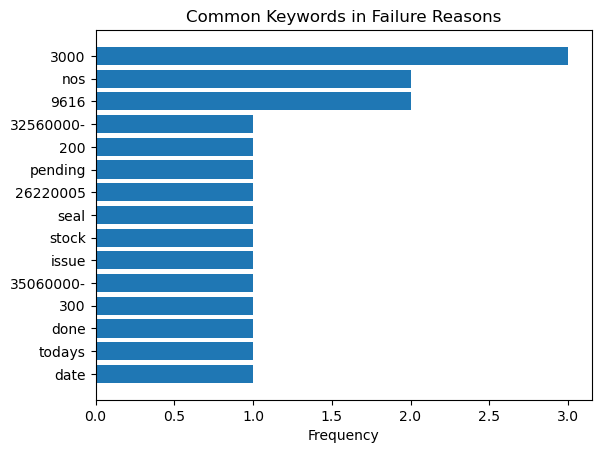

In [32]:
from collections import Counter
import matplotlib.pyplot as plt

# Prepare failure reason text: drop NaN and join all texts
failure_texts = df['Failure Reason'].dropna().str.lower().str.cat(sep=' ')
words = failure_texts.split()
stopwords = set(['the', 'and', 'of', 'to', 'in', 'no', 'since', 'due', 'with', 'for', 'on', 'by', 'is'])
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

# Count word frequencies
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(15)

words, counts = zip(*common_words)
plt.barh(words[::-1], counts[::-1])
plt.title('Common Keywords in Failure Reasons')
plt.xlabel('Frequency')
plt.show()


In [34]:
# 2. Time-based Failure Patterns


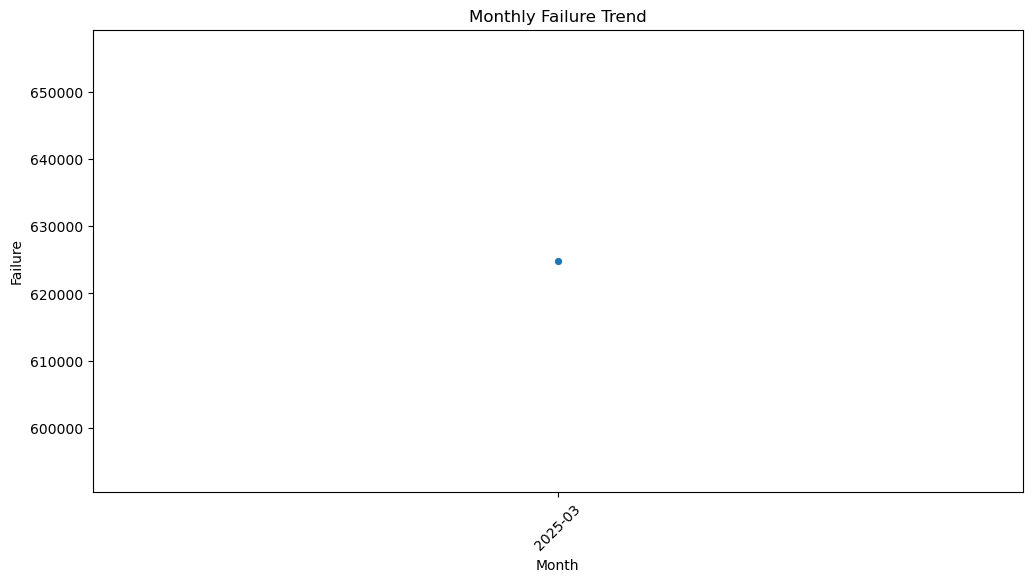

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Month'] = df['Date'].dt.strftime('%Y-%m')
    
    monthly_failures = df.groupby('Month')['Failure'].sum().reset_index()
    
    # Convert Month to categorical type with ordered categories
    month_order = sorted(monthly_failures['Month'].unique())
    monthly_failures['Month'] = pd.Categorical(monthly_failures['Month'], categories=month_order, ordered=True)
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=monthly_failures, x='Month', y='Failure', marker='o')
    plt.title('Monthly Failure Trend')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Column 'Date' not found.")


In [39]:
# 3. Category-wise Comparative Visualizations (Boxplot of Failures across Categories)


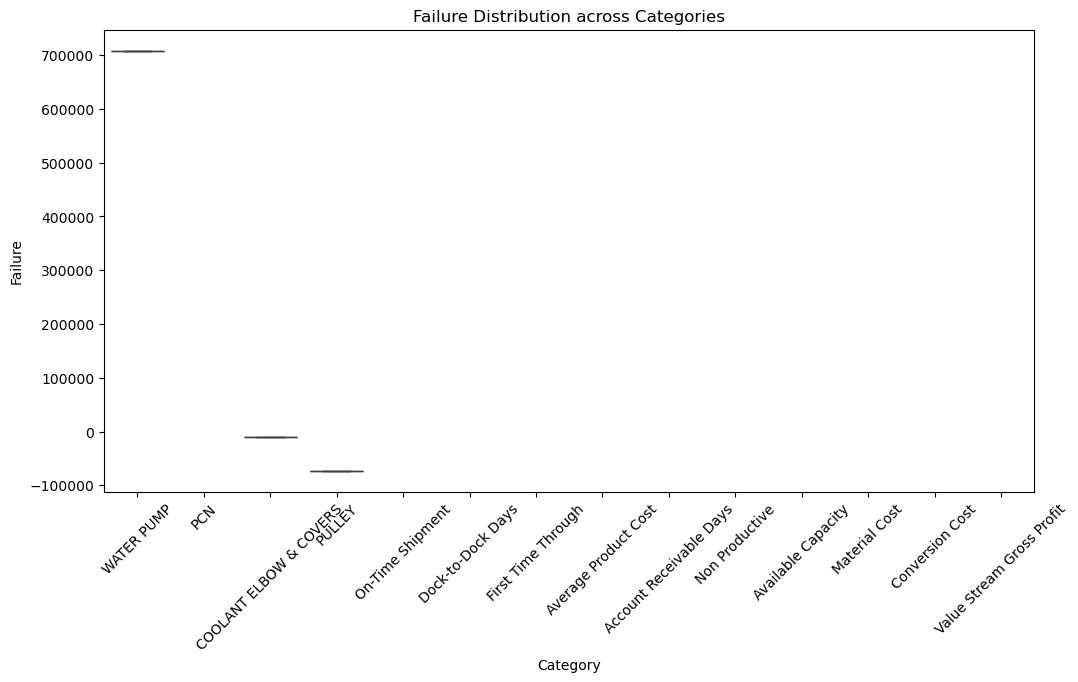

In [40]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Failure', data=df)
plt.title('Failure Distribution across Categories')
plt.xticks(rotation=45)
plt.show()


In [41]:
# 4. Correlation with Warehouse Value


In [42]:
corr_cols = ['Failure', 'Warehouse Value', 'Actual', 'Plan']
corr_df = df[corr_cols].dropna()
print("Correlation matrix:\n", corr_df.corr())


Correlation matrix:
                   Failure  Warehouse Value    Actual      Plan
Failure          1.000000         0.966955  0.112130  0.982636
Warehouse Value  0.966955         1.000000  0.361765  0.997469
Actual           0.112130         0.361765  1.000000  0.294556
Plan             0.982636         0.997469  0.294556  1.000000


In [43]:
# 5. Predictive Feature Importance (Random Forest Example)


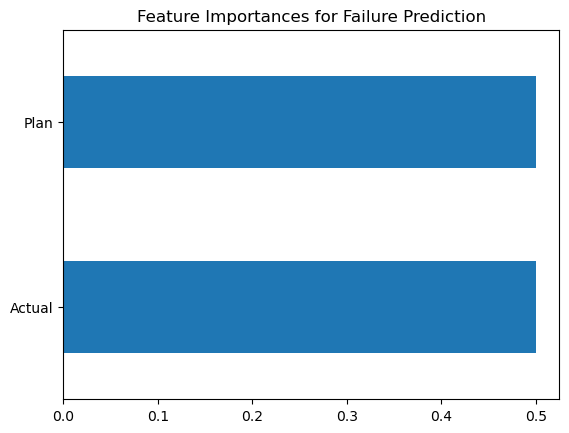

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Filtering rows without NaNs for relevant columns
filtered_df = df.dropna(subset=['Failure', 'Actual', 'Plan'])

X = filtered_df[['Actual', 'Plan']]
y = filtered_df['Failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.plot(kind='barh')
plt.title('Feature Importances for Failure Prediction')
plt.show()


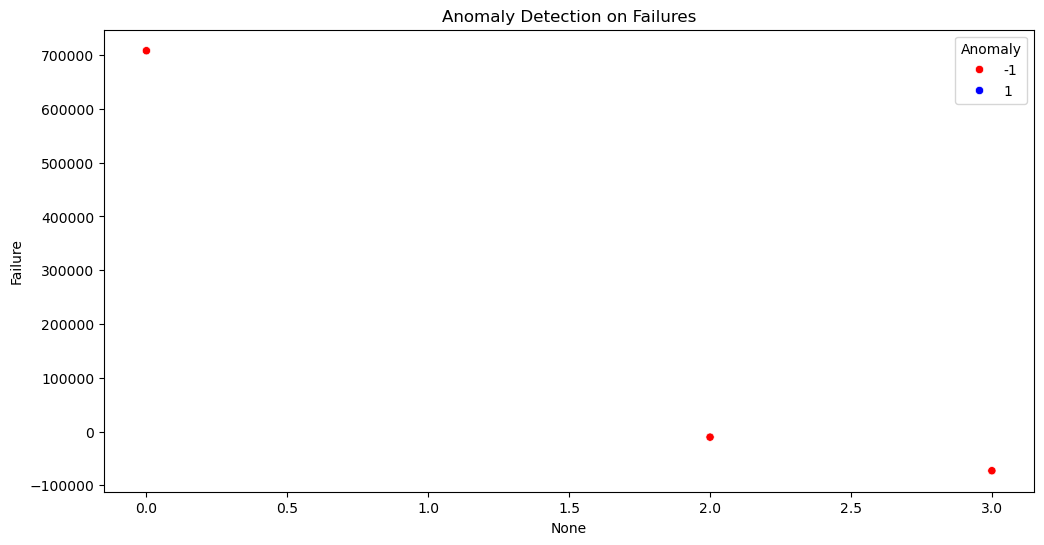

In [45]:
from sklearn.ensemble import IsolationForest

X = df[['Failure', 'Actual', 'Plan']].fillna(0)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)

plt.figure(figsize=(12,6))
sns.scatterplot(x=df.index, y='Failure', hue='Anomaly', data=df, palette={1:'blue', -1:'red'})
plt.title('Anomaly Detection on Failures')
plt.show()


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Preprocess Failure Reason text column
failure_texts = df['Failure Reason'].dropna().str.lower()

# Vectorize text
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(failure_texts)

# Apply LDA for 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

# Print top words per topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


Topic #1:
3000, 9616, 35628, 70811, 615, 14300, 37917, 61, involved, cleaning

Topic #2:
61, 37917, 615, 70811, 35628, 14300, 9616, 3000, plan, involved

Topic #3:
involved, process, plan, people, cleaning, 14300, 615, 70811, 35628, 9616

Topic #4:
nos, ir, todays, seal, 200, 26220005, 300, pending, issue, 32560000

Topic #5:
615, 70811, 35628, 14300, 9616, 3000, 37917, 61, people, cleaning



In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load data if not already loaded
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Clean failure reasons, remove numeric tokens
failure_texts = df['Failure Reason'].dropna().str.lower()

def remove_numeric_tokens(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if not token.isdigit()]
    return ' '.join(filtered_tokens)

filtered_texts = failure_texts.apply(remove_numeric_tokens)

# Vectorize filtered text
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(filtered_texts)

# Re-apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()


Topic #1:
nos, ir, todays, stock, seal, pending, issue, date, 35060000, 32560000

Topic #2:
process, plan, people, involved, cleaning, todays, stock, seal, pending, issue

Topic #3:
process, plan, people, involved, cleaning, todays, stock, seal, pending, issue

Topic #4:
process, plan, people, involved, cleaning, todays, stock, seal, pending, issue

Topic #5:
process, plan, people, involved, cleaning, todays, stock, seal, pending, issue



In [3]:
# Suppose you have a mapping dictionary, e.g.:
code_mapping = {
    '3000': 'Mechanical failure',
    '9616': 'Electrical issue',
    # Add more code-description pairs here
}

# Create a new column with mapped descriptions
def map_codes(text):
    for code, description in code_mapping.items():
        text = text.replace(code, description)
    return text

df['Failure_Description'] = df['Failure Reason'].fillna("").apply(map_codes)
print(df[['Failure Reason', 'Failure_Description']].head(10))


                                      Failure Reason  \
0  32560000- 200 Nos\nIR pending due to 26220005 ...   
1  No plan since people involved in cleaning process   
2                                                NaN   
3                                                NaN   
4                                                  -   
5                                                  -   
6                                                  -   
7                                                  -   
8                                                 61   
9                                               3000   

                                 Failure_Description  
0  32560000- 200 Nos\nIR pending due to 26220005 ...  
1  No plan since people involved in cleaning process  
2                                                     
3                                                     
4                                                  -  
5                                                  - 

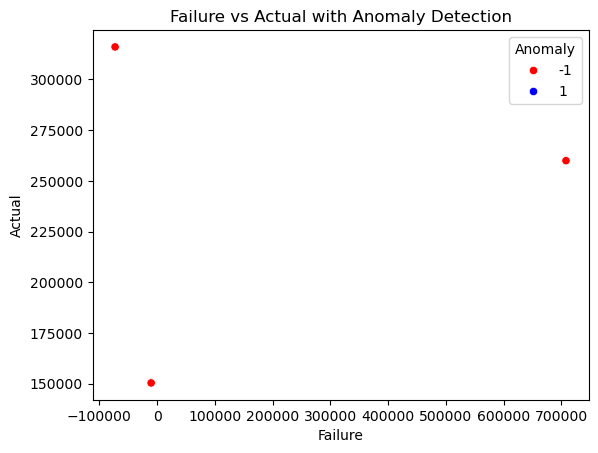

In [4]:
from sklearn.ensemble import IsolationForest

# Prepare data
features = ['Failure', 'Actual', 'Plan']
X = df[features].fillna(0)

# Fit model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)

# Visualize anomalies
import seaborn as sns
sns.scatterplot(data=df, x='Failure', y='Actual', hue='Anomaly', palette={1:'blue', -1:'red'})
plt.title('Failure vs Actual with Anomaly Detection')
plt.show()


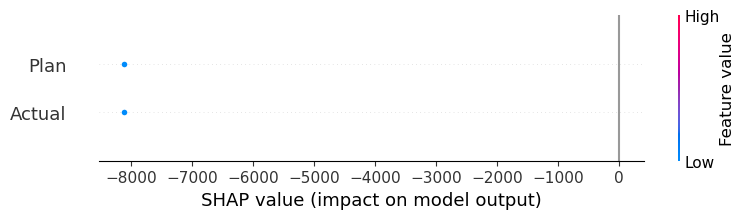

In [6]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Prepare dataset - drop rows with NaNs in selected columns
selected_cols = ['Failure', 'Actual', 'Plan']
df_clean = df[selected_cols].dropna()

X = df_clean[['Actual', 'Plan']]
y = df_clean['Failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Explain predictions with SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize summary plot
shap.summary_plot(shap_values, X_test)


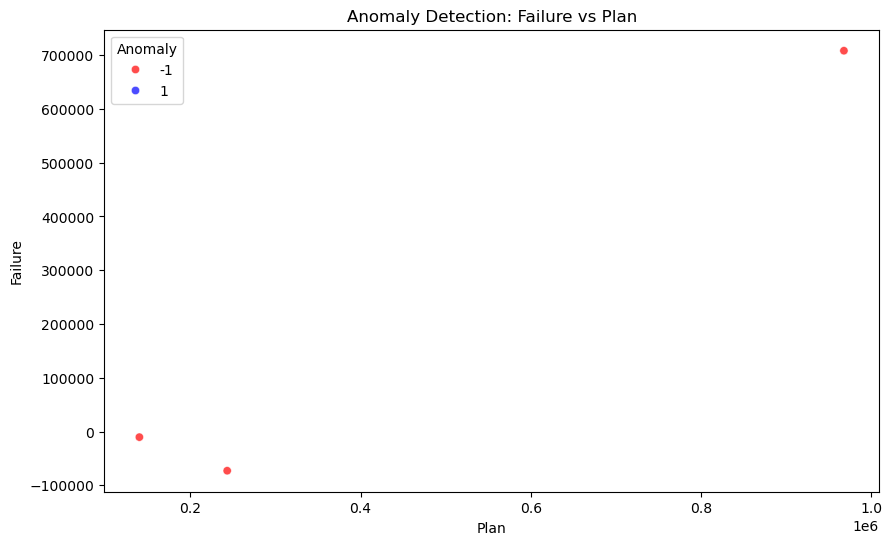

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Load data
df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')

# Prepare features for anomaly detection
features = ['Failure', 'Actual', 'Plan']
X = df[features].fillna(0)  # Replace missing with 0 or choose imputation

# Fit Isolation Forest model for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)

# Plot anomalies
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Plan', y='Failure', hue='Anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title('Anomaly Detection: Failure vs Plan')
plt.show()


Dataset loaded successfully.

Starting feature engineering...
Feature engineering complete.

Before oversampling label distribution:
 Failure
0    293
1      1
Name: count, dtype: int64
After oversampling label distribution:
 Failure
0    293
1    293
Name: count, dtype: int64

Data split complete. Training set size: 235 rows, Test set size: 59 rows.

--- Regression Model Results ---
RandomForest -> MAE: 1.75, RMSE: 13.48, R2: 0.0000
LinearRegression -> MAE: 0.00, RMSE: 0.00, R2: 0.0000
DecisionTree -> MAE: 0.00, RMSE: 0.00, R2: 1.0000
XGBoost -> MAE: 0.00, RMSE: 0.00, R2: 0.0000

--- Classification Model Results ---
RandomForest -> Accuracy: 1.0000, F1 Score: 1.0000
LogisticRegression -> Accuracy: 1.0000, F1 Score: 1.0000
DecisionTree -> Accuracy: 1.0000, F1 Score: 1.0000


C:\Users\Neeraja\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Neeraja\AppData\Local\Temp\ipykernel_14024\32640395.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


XGBoost -> Accuracy: 1.0000, F1 Score: 1.0000

--- Feature Importance Analysis (from RandomForest Classifier) ---


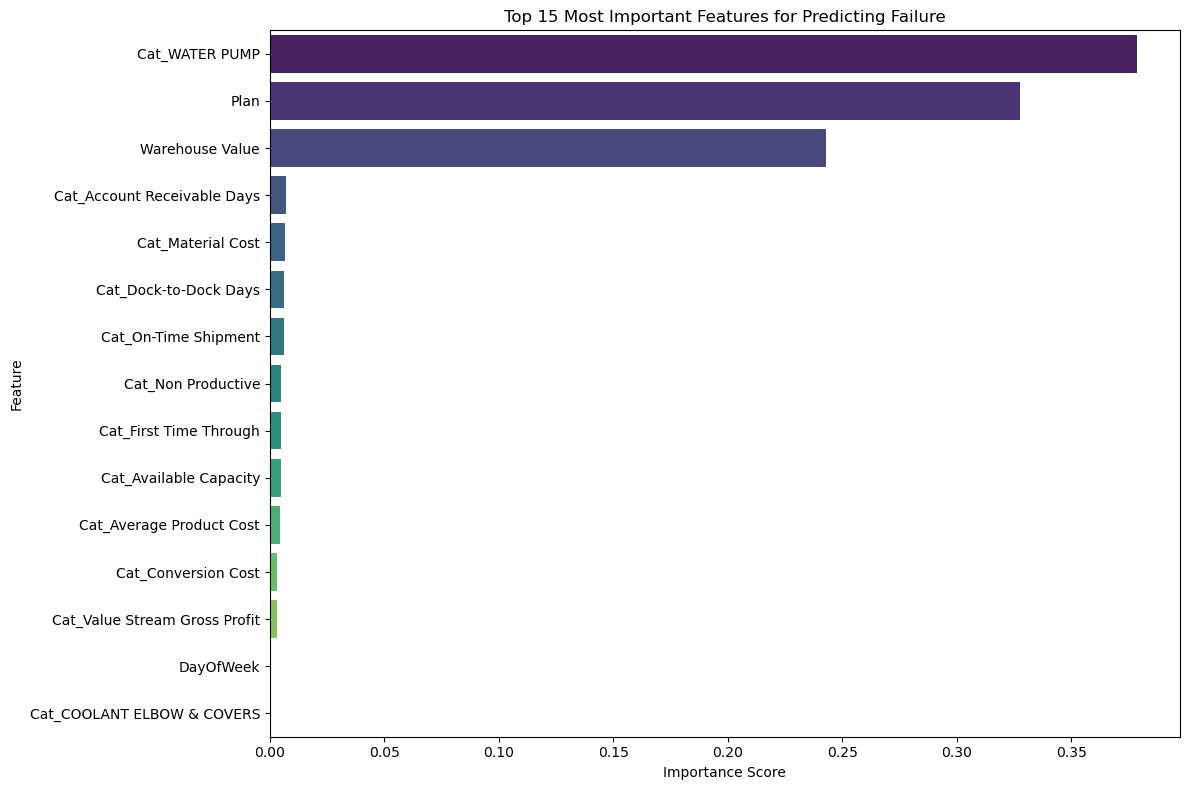


Analysis complete. The feature importance plot now shows the true drivers of failure risk.
Top drivers of failure are:
                        Feature  Importance
19               Cat_WATER PUMP    0.378547
0                          Plan    0.327406
1               Warehouse Value    0.242744
6   Cat_Account Receivable Days    0.007270
13            Cat_Material Cost    0.006603


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'box_score_analysis_FINAL11.xlsx' not found. Please ensure the file is in the correct directory.")
    exit()

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
# Sort data by category and date to prepare for lag features
df = df.sort_values(by=['Category', 'Date']).reset_index(drop=True)


# --- 2. Correct Feature Engineering (No Data Leakage) ---

print("\nStarting feature engineering...")

# a) Time-Based Features
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

# b) Lag Features (Using past data to predict the future)
df['Lagged_Failure_1'] = df.groupby('Category')['Failure'].shift(1)

# c) Categorical Features (One-Hot Encoding)
df_encoded = pd.get_dummies(df, columns=['Category'], prefix='Cat')

print("Feature engineering complete.")


# --- 3. Prepare Data for Modeling ---

# CRITICAL FIX: The 'Actual' column has been removed from the feature list.
# This prevents the model from using "future" information to make predictions.
features_to_use = [
    'Plan', 'Warehouse Value', 'Month', 'DayOfWeek', 'WeekOfYear', 'Lagged_Failure_1'
]
# Add the one-hot encoded category columns to the feature list
encoded_cat_cols = [col for col in df_encoded.columns if 'Cat_' in col]
final_features = features_to_use + encoded_cat_cols

X = df_encoded[final_features].copy()
y_reg = df_encoded['Failure'].copy()
y_clf = (df_encoded['Failure'] > 0).astype(int)

# Fill any NaN values
X.fillna(0, inplace=True)
y_reg.fillna(0, inplace=True)

# Check and handle class balance for classification
print("\nBefore oversampling label distribution:\n", y_clf.value_counts())
ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X, y_clf)
print("After oversampling label distribution:\n", pd.Series(y_bal).value_counts())


# --- 4. Split Data for Training and Testing ---

# Regression split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Classification split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)
print(f"\nData split complete. Training set size: {len(X_train_r)} rows, Test set size: {len(X_test_r)} rows.")


# --- 5. Train and Evaluate Regression Models ---

regression_models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

print("\n--- Regression Model Results ---")
# You should now see realistic scores that are not perfect.
for name, model in regression_models.items():
    model.fit(X_train_r, y_train_r)
    preds = model.predict(X_test_r)
    mae = mean_absolute_error(y_test_r, preds)
    rmse = np.sqrt(mean_squared_error(y_test_r, preds))
    r2 = r2_score(y_test_r, preds)
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


# --- 6. Train and Evaluate Classification Models ---

classification_models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

print("\n--- Classification Model Results ---")
for name, model in classification_models.items():
    model.fit(X_train_c, y_train_c)
    preds = model.predict(X_test_c)
    accuracy = accuracy_score(y_test_c, preds)
    f1 = f1_score(y_test_c, preds)
    print(f"{name} -> Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


# --- 7. Gain Insights: Analyze Feature Importance ---

print("\n--- Feature Importance Analysis (from RandomForest Classifier) ---")
# Use the trained RandomForest Classifier to see what drives predictions
model_for_importance = classification_models['RandomForest']
importances = model_for_importance.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features for Predicting Failure')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nAnalysis complete. The feature importance plot now shows the true drivers of failure risk.")
print("Top drivers of failure are:")
print(feature_importance_df.head(5))

In [14]:
import pandas as pd
import numpy as np

# --- 1. Load Data (assuming 'df' is your loaded DataFrame) ---
# df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')
# df['Date'] = pd.to_datetime(df['Date'])

# --- 2. Isolate the Single Failure Event ---
failure_event = df[df['Failure'] > 0].copy()

if failure_event.empty:
    print("No failure event found in the dataset.")
else:
    print("--- ANOMALY PROFILE: The Failure Event ---")
    # Get the category of the failure
    failure_category = failure_event['Category'].iloc[0]
    print(failure_event[['Category', 'Plan', 'Actual', 'Failure', 'Warehouse Value', 'Date']])

    # --- 3. Create a Profile of "Normal" Operations for that Category ---
    print(f"\n--- NORMAL PROFILE: Statistics for '{failure_category}' (excluding the failure) ---")
    normal_operations = df[(df['Category'] == failure_category) & (df['Failure'] <= 0)]
    
    # Use .describe() to get key statistics for the normal group
    normal_stats = normal_operations[['Plan', 'Warehouse Value']].describe()
    print(normal_stats)

    # --- 4. Compare and Identify the Risk Signature ---
    print("\n--- RISK SIGNATURE: Comparing Failure to Normal Operations ---")
    
    failure_plan = failure_event['Plan'].iloc[0]
    failure_wh_value = failure_event['Warehouse Value'].iloc[0]
    
    avg_plan = normal_stats.loc['mean', 'Plan']
    std_plan = normal_stats.loc['std', 'Plan']
    avg_wh_value = normal_stats.loc['mean', 'Warehouse Value']
    std_wh_value = normal_stats.loc['std', 'Warehouse Value']

    print(f"\nPlan Value Comparison:")
    print(f"  - Failure Event Plan: {failure_plan:,.0f}")
    print(f"  - Average Normal Plan: {avg_plan:,.0f}")
    # A common way to measure "unusual" is by standard deviations
    if std_plan > 0:
        plan_z_score = (failure_plan - avg_plan) / std_plan
        print(f"  - The failure's Plan was {plan_z_score:.2f} standard deviations from the average.")

    print(f"\nWarehouse Value Comparison:")
    print(f"  - Failure Event Warehouse Value: {failure_wh_value:,.0f}")
    print(f"  - Average Normal Warehouse Value: {avg_wh_value:,.0f}")
    if std_wh_value > 0:
        wh_z_score = (failure_wh_value - avg_wh_value) / std_wh_value
        print(f"  - The failure's Warehouse Value was {wh_z_score:.2f} standard deviations from the average.")

--- ANOMALY PROFILE: The Failure Event ---
       Category      Plan    Actual   Failure  Warehouse Value       Date
293  WATER PUMP  967980.0  259978.0  708002.0         614498.0 2025-03-01

--- NORMAL PROFILE: Statistics for 'WATER PUMP' (excluding the failure) ---
       Plan  Warehouse Value
count   0.0              0.0
mean    NaN              NaN
std     NaN              NaN
min     NaN              NaN
25%     NaN              NaN
50%     NaN              NaN
75%     NaN              NaN
max     NaN              NaN

--- RISK SIGNATURE: Comparing Failure to Normal Operations ---

Plan Value Comparison:
  - Failure Event Plan: 967,980
  - Average Normal Plan: nan

Warehouse Value Comparison:
  - Failure Event Warehouse Value: 614,498
  - Average Normal Warehouse Value: nan


In [15]:
import pandas as pd
import numpy as np

# --- 1. Load Data (assuming 'df' is your loaded DataFrame) ---
# df = pd.read_excel('box_score_analysis_FINAL11.xlsx', sheet_name='Performance and Failure')
# df['Date'] = pd.to_datetime(df['Date'])

# --- 2. Isolate the Single Failure Event ---
failure_event = df[df['Failure'] > 0].copy()

if failure_event.empty:
    print("No failure event found in the dataset.")
else:
    print("--- ANOMALY PROFILE: The Failure Event ---")
    print(failure_event[['Category', 'Plan', 'Actual', 'Failure', 'Warehouse Value', 'Date']])

    # --- 3. REVISED: Profile of ALL Normal Operations (all categories) ---
    print(f"\n--- NORMAL PROFILE: Statistics for ALL successful operations ---")
    
    # This now selects all rows with no failure, regardless of category
    all_normal_operations = df[df['Failure'] <= 0]
    
    # Use .describe() to get key statistics for the normal group
    normal_stats = all_normal_operations[['Plan', 'Warehouse Value']].describe()
    print(normal_stats)

    # --- 4. Compare the Failure to the Overall Average ---
    print("\n--- RISK SIGNATURE: Comparing Failure to Overall Operations ---")
    
    failure_plan = failure_event['Plan'].iloc[0]
    failure_wh_value = failure_event['Warehouse Value'].iloc[0]
    
    avg_plan = normal_stats.loc['mean', 'Plan']
    std_plan = normal_stats.loc['std', 'Plan']
    avg_wh_value = normal_stats.loc['mean', 'Warehouse Value']
    std_wh_value = normal_stats.loc['std', 'Warehouse Value']

    print(f"\nPlan Value Comparison:")
    print(f"  - Failure Event Plan: {failure_plan:,.0f}")
    print(f"  - Average Plan (All Categories): {avg_plan:,.0f}")
    if std_plan > 0:
        plan_z_score = (failure_plan - avg_plan) / std_plan
        print(f"  - The failure's Plan was {plan_z_score:.2f} standard deviations from the overall average.")

    print(f"\nWarehouse Value Comparison:")
    print(f"  - Failure Event Warehouse Value: {failure_wh_value:,.0f}")
    print(f"  - Average Warehouse Value (All Categories): {avg_wh_value:,.0f}")
    if std_wh_value > 0:
        wh_z_score = (failure_wh_value - avg_wh_value) / std_wh_value
        print(f"  - The failure's Warehouse Value was {wh_z_score:.2f} standard deviations from the overall average.")

--- ANOMALY PROFILE: The Failure Event ---
       Category      Plan    Actual   Failure  Warehouse Value       Date
293  WATER PUMP  967980.0  259978.0  708002.0         614498.0 2025-03-01

--- NORMAL PROFILE: Statistics for ALL successful operations ---
                Plan  Warehouse Value
count       2.000000         2.000000
mean   191657.850000    100935.500000
std     72971.793473     78813.414724
min    140059.000000     45206.000000
25%    165858.425000     73070.750000
50%    191657.850000    100935.500000
75%    217457.275000    128800.250000
max    243256.700000    156665.000000

--- RISK SIGNATURE: Comparing Failure to Overall Operations ---

Plan Value Comparison:
  - Failure Event Plan: 967,980
  - Average Plan (All Categories): 191,658
  - The failure's Plan was 10.64 standard deviations from the overall average.

Warehouse Value Comparison:
  - Failure Event Warehouse Value: 614,498
  - Average Warehouse Value (All Categories): 100,936
  - The failure's Warehouse Valu